In [ ]:
# OPTIMAL HYPERPARAMETERS - Based on empirical results
K = 5
N_VAL_USERS = 40  # ⬆️ Bilanciato (era 5, troppo poco; 30 funziona ma 20 è sufficiente)

EPOCHS = 400  # ⬆️ Increased (ma con early stopping)
PATIENCE = 40  # ⬆️ Slightly increased
VERBOSE = 10

LEARNING_RATE = 5e-4  # ✅ Keep (buono)
BATCH_SIZE = 256  # ✅ Keep (riduce overfitting)
WINDOW_SIZE = 100  # ✅ Keep (BEST from both searches)
STRIDE = 25  # ✅ Keep (BEST from both searches)
RNN_TYPE = 'GRU'  # ✅ Keep
BIDIRECTIONAL = True  # ✅ Keep

HIDDEN_LAYERS = 2  # ✅ Keep
HIDDEN_SIZE = 96  # 🔧 COMPROMISE (tra 64 e 128)

DROPOUT_RATE = 0.3  # 🔧 REDUCED from 0.4 (più bilanciato)
L1_LAMBDA = 0  # ✅ Keep
L2_LAMBDA = 5e-5  # 🔧 REDUCED from 1e-4 (meno aggressivo)




# Reverse mapping from integers to pain level names
label_reverse_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Create mapping dictionary for pain levels
pain_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

labels = ['no_pain', 'low_pain', 'high_pain']

num_classes = len(labels)

# Define parameters to search
param_grid = {
    'window_size': [50, 100, 160],
    'stride': [10, 25, 50, 70],
    'n_val_users' : [30, 40, 50, 60],
    'hidden_size': [64, 96, 128],
    'hidden_layers': [1, 2, 3, 5],
    'batch_size': [64, 128, 256, 512],
    'k' : [3, 5, 7]
}




In [2]:
# Set seed for reproducibility
SEED = 42
LOCAL = True

# Import necessary libraries
import os, subprocess, shlex

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)


def mac_physical_cores():
    try:
        out = subprocess.check_output(shlex.split("sysctl -n hw.physicalcpu")).decode().strip()
        return int(out)
    except Exception:
        return max(1, (os.cpu_count() or 2) // 2)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

if (LOCAL):

    PHYS = mac_physical_cores()

    # Leave one core free for the OS (helps thermals on Airs)
    OMP = max(1, PHYS - 1)

    # --- OpenMP / BLAS knobs (set BEFORE importing torch) ---
    os.environ.setdefault("OMP_NUM_THREADS", str(OMP))            # OpenMP (oneDNN, some kernels)
    os.environ.setdefault("VECLIB_MAXIMUM_THREADS", str(OMP))     # Apple Accelerate / vecLib
    os.environ.setdefault("OPENBLAS_NUM_THREADS", str(OMP))       # If any dep uses OpenBLAS
    os.environ.setdefault("MKL_NUM_THREADS", str(OMP))            # Rare on macOS, harmless if unused
    os.environ.setdefault("MKL_DYNAMIC", "FALSE")                 # Avoid oversubscription if MKL present

    device = torch.device("cpu")  # Intel Mac: CPU only

    torch.manual_seed(SEED)
    torch.set_num_threads(OMP)        # intra-op threads
    torch.set_num_interop_threads(1)  # parallel ops; start low on laptops

    print(f"device={device}, physical_cores={PHYS}, "
        f"OMP_NUM_THREADS={OMP}, "
        f"torch_threads={torch.get_num_threads()}, "
        f"interop={torch.get_num_interop_threads()}")





print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

device=cpu, physical_cores=4, OMP_NUM_THREADS=3, torch_threads=3, interop=1
PyTorch version: 2.9.0+cu128
Device: cpu


sysctl: cannot stat /proc/sys/hw/physicalcpu: No such file or directory


In [3]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')


# First map the labels in y_train
y_train['label_encoded'] = y_train['label'].map(pain_mapping)

# Then merge with X_train based on sample_index
X_train = X_train.merge(
    y_train[['sample_index', 'label_encoded']],
    on='sample_index',
    how='left'
)

# Rename the column
X_train.rename(columns={'label_encoded': 'label'}, inplace=True)

# Verify the mapping worked correctly
print("\nFirst few rows of X_train with encoded labels:")
print(X_train[['sample_index', 'label']].head(10))

print("\nLabel value counts:")
print(X_train['label'].value_counts())

print("\nCheck for NaN labels:")
print(f"NaN count: {X_train['label'].isna().sum()}")

input_shape = X_train.shape[1:]




First few rows of X_train with encoded labels:
   sample_index  label
0             0      0
1             0      0
2             0      0
3             0      0
4             0      0
5             0      0
6             0      0
7             0      0
8             0      0
9             0      0

Label value counts:
label
0    81760
1    15040
2     8960
Name: count, dtype: int64

Check for NaN labels:
NaN count: 0


In [4]:
# Drop joint_30 column (contains only NaN values)
print("Dropping joint_30 column (all NaN values)...")
for df in [X_train]:
    if 'joint_30' in df.columns:
        df.drop('joint_30', axis=1, inplace=True)
        print(f"Dropped joint_30 from {df.shape}")

print("\nColumns after dropping joint_30:")
print(f"X_train columns: {X_train.shape[1]}")

Dropping joint_30 column (all NaN values)...
Dropped joint_30 from (105760, 40)

Columns after dropping joint_30:
X_train columns: 40


In [5]:
# print("\n--- Data successfully loaded ---")
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}")

# print("\n--- Initial Feature Count Breakdown ---")
# all_features = X_train.columns.drop(['sample_index', 'time'])
# joint_features = [col for col in all_features if col.startswith('joint_')]
# static_features = [col for col in all_features if col in ['n_legs', 'n_hands', 'n_eyes']]

# print(f"Total Features (excluding IDs): {len(all_features)}")
# print(f"Core Time-Series (Joints): {len(joint_features)} columns")
# print(f"Static Subject Characteristics: {len(static_features)} columns")
# print(f"Pain Survey Features: {len(all_features) - len(joint_features) - len(static_features)} columns")




In [6]:
# First: Convert categorical variables to binary (two -> 1, others -> 0)
binary_cols = ['n_hands', 'n_eyes', 'n_legs']
for col in binary_cols:
    for df_ in [X_train]:
        df_[col] = df_[col].map(lambda x: 1 if str(x).lower().strip() == 'two' else 0)


In [7]:
print("\n--- Data structure ---")
print("\nX_train Info:")
X_train.info(verbose=True)
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print("\ny_train Info:")
y_train.info(verbose=True)
print(f"\nMissing values in y_train: {y_train.isnull().sum().sum()}")


--- Data structure ---

X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  int64  
 7   n_hands        105760 non-null  int64  
 8   n_eyes         105760 non-null  int64  
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  flo

In [8]:
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.990923,0.990923,0.990923,0.943095,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.311649
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094841,0.094841,0.094841,0.202051,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.619651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.828277,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.000000
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.005126,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.000000
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.081039,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.000000
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.407968,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,2.000000


In [9]:
def build_sequences(df, window=200, stride=50):
    """
    Build sequences from time-series data

    Args:
        df: DataFrame with the data
        window: Window size for sequences
        stride: Stride for overlapping windows

    Returns:
        dataset: numpy array of sequences
        labels: numpy array of labels
    """
    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for sample_id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        drop_cols = [c for c in ['sample_index', 'time', 'label', 'labels'] if c in df.columns]
        temp = df[df['sample_index'] == sample_id].drop(columns=drop_cols).values.astype('float32')

        # Retrieve the activity label for the current ID
        label_series = df[df['sample_index'] == sample_id]['label']

        # Check if label column exists and has values
        if label_series.empty:
            print(f"Warning: No label found for sample_id {sample_id}")
            continue

        label_value = label_series.values[0]

        # Skip samples with NaN labels
        if pd.isna(label_value):
            print(f"Warning: NaN label for sample_id {sample_id}, skipping...")
            continue

        # Convert to int and validate
        try:
            label = int(label_value)
            if label < 0 or label > 2:  # Assuming 3 classes: 0, 1, 2
                print(f"Warning: Invalid label {label} for sample_id {sample_id}, skipping...")
                continue
        except (ValueError, TypeError) as e:
            print(f"Warning: Cannot convert label {label_value} to int for sample_id {sample_id}: {e}")
            continue

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window if len(temp) % window != 0 else 0

        # Create zero padding with correct number of features
        if padding_len > 0:
            padding = np.zeros((padding_len, temp.shape[1]), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset, dtype='float32')
    labels = np.array(labels, dtype='int64')

    print(f"Built {len(dataset)} sequences with {len(labels)} labels")

    return dataset, labels

In [10]:
BATCH_SIZE = 512

In [11]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [12]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [13]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 128], [2, -1]]         54,912         
classifier (Linear)       [-1]                         387            
Total params: 55,299
Trainable params: 55,299
Non-trainable params: 0
-------------------------------------------------------------------------------


In [14]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [15]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [16]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [17]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [18]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

# KFOLD

In [19]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with sample-based splitting for Pirate Pain time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'time', 'label', 'pain_survey_*', 'joint_*', 'n_legs', 'n_hands', 'n_eyes']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of samples for validation set
        n_test_users: Number of samples for test set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Define pain level mapping
    pain_mapping = {
        'no_pain': 0,
        'low_pain': 1,
        'high_pain': 2
    }

    # Define columns to normalize
    pain_survey_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes']
    joint_columns = [f'joint_{i:02d}' for i in range(30)]  # joint_00 through joint_29
    scale_columns = pain_survey_columns + joint_columns

    # Get model architecture parameters
    # Count features (excluding sample_index, time, label)
    feature_cols = scale_columns  # All features that will be used
    in_features = len(feature_cols)
    num_classes = 3  # no_pain, low_pain, high_pain

    # Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique sample IDs and shuffle them with split-specific seed
        unique_samples = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_samples)

        # Calculate the number of samples for the training set
        n_train_samples = len(unique_samples) - n_val_users

        # Split the shuffled sample IDs into training, validation, and test sets
        train_samples = unique_samples[:n_train_samples]
        val_samples = unique_samples[n_train_samples:n_train_samples + n_val_users]

        # Split the dataset into training, validation, and test sets based on sample IDs
        df_train = df[df['sample_index'].isin(train_samples)].copy()
        df_val = df[df['sample_index'].isin(val_samples)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")

        # Map pain labels to integers (if not already mapped)
        if df_train['label'].dtype == 'object':
            df_train['label'] = df_train['label'].map(pain_mapping)
            df_val['label'] = df_val['label'].map(pain_mapping)

        # Normalise features using training set statistics
        train_max = df_train[scale_columns].max()
        train_min = df_train[scale_columns].min()

        for column in scale_columns:
            df_train[column] = (df_train[column] - train_min[column]) / (train_max[column] - train_min[column] + 1e-8)
            df_val[column] = (df_val[column] - train_min[column]) / (train_max[column] - train_min[column] + 1e-8)

        # Build sequences using the existing build_sequences function
        X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
        X_val, y_val = build_sequences(df_val, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            print(f"  Test sequences shape: {X_test.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [20]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [21]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()


In [22]:
%%time

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=X_train,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/1:
  window_size: 50
  stride: 25
  n_val_users: 30
Built 4417 sequences with 4417 labels
Built 210 sequences with 210 labels
Training 1 epochs...
Best model restored from epoch 1 with val_f1 0.8048
Built 4417 sequences with 4417 labels
Built 210 sequences with 210 labels
Training 1 epochs...
Best model restored from epoch 1 with val_f1 0.4912
  NEW BEST SCORE!
  F1 Score: 0.6480±0.1568
CPU times: user 51.2 s, sys: 2.64 s, total: 53.8 s
Wall time: 24.5 s


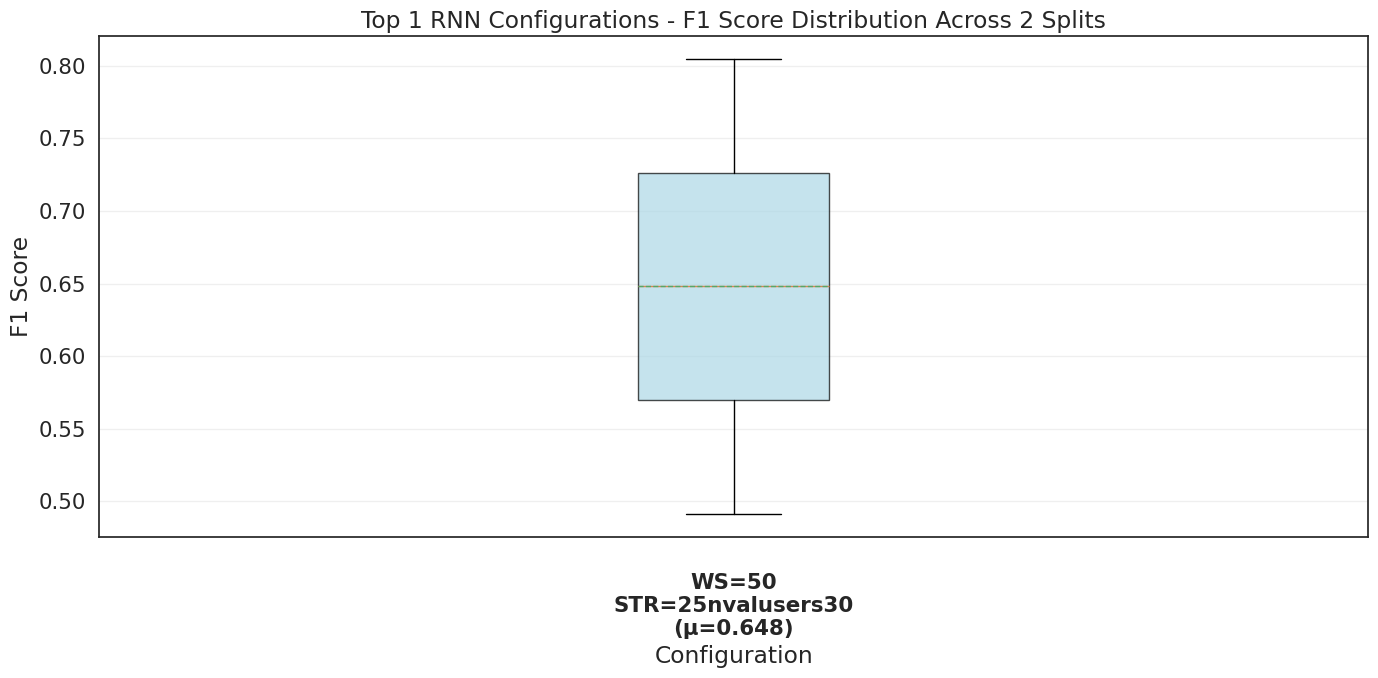

In [23]:
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

# Prediction

In [24]:
%%time

final_best_params = {**fixed_params, **best_config}

X_test = pd.read_csv('pirate_pain_test.csv')

# Drop joint_30 column (contains only NaN values)
print("Dropping joint_30 column (all NaN values)...")
for df in [X_test]:
    if 'joint_30' in df.columns:
        df.drop('joint_30', axis=1, inplace=True)
        print(f"Dropped joint_30 from {df.shape}")



# --- 1. Prepare test data without labels ---
print("Preparing test data for prediction...")


num_classes = len(label_reverse_mapping)

# Apply initial preprocessing steps as done for the training data
# Drop joint_30 if it exists
if 'joint_30' in X_test.columns:
    X_test.drop('joint_30', axis=1, inplace=True)

# Convert categorical variables to binary
binary_cols = ['n_hands', 'n_eyes', 'n_legs']
for col in binary_cols:
    X_test[col] = X_test[col].map(lambda x: 1 if str(x).lower().strip() == 'two' else 0)

# Store original test data before further preprocessing (for final CSV)
df_test_original = X_test.copy()

# --- 2. Get normalization parameters from ORIGINAL training data (X_train, not df_train) ---
# Use the full training set before any splits
pain_survey_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes']
joint_columns = [f'joint_{i:02d}' for i in range(30)]  # joint_00 through joint_29
scale_columns = pain_survey_columns + joint_columns

# Get normalization parameters from the FULL training data (before CV splits)
# X_train is still a DataFrame (checked in kernel state)
train_max = X_train[scale_columns].max()
train_min = X_train[scale_columns].min()

# --- 3. Apply preprocessing to test data ---
df_test_processed = X_test.copy() # Use the reloaded, preprocessed test data

# Apply same normalization as training
for column in scale_columns:
    df_test_processed[column] = (df_test_processed[column] - train_min[column]) / (train_max[column] - train_min[column] + 1e-8)

# --- 4. Build test sequences using BEST parameters from grid search ---
df_test_processed['label'] = 0  # Dummy label (required by build_sequences)

# Use the best window and stride from grid search
X_test_sequences, _ = build_sequences(
    df_test_processed,
    window=best_config['window_size'],
    stride=best_config['stride']
)

print(f"Test sequences shape: {X_test_sequences.shape}")
print(f"Number of test sequences: {len(X_test_sequences)}")
print(f"Using best config: window_size={best_config['window_size']}, stride={best_config['stride']}")


# --- 5. Initialize model with BEST parameters from grid search ---
model = RecurrentClassifier(
    input_size=X_test_sequences.shape[2],  # num_features (37)
    hidden_size=final_best_params['hidden_size'],
    num_layers=final_best_params['hidden_layers'],
    num_classes=num_classes,  # 3 classes
    dropout_rate=final_best_params['dropout_rate'],
    bidirectional=final_best_params['bidirectional'],
    rnn_type=final_best_params['rnn_type']
).to(device)

# --- 6. Load the BEST model from grid search ---
# Use the model from the first split (split_0) of the best configuration
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])
model_path = f"models/{best_config_str}/split_0_model.pt"

print(f"\nLoading best model from: {model_path}")
print(f"Model configuration: {final_best_params}")

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✓ Model loaded successfully")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {model_path}")
    print("Available model files:")
    import glob
    for f in glob.glob("models/**/*.pt", recursive=True):
        print(f"  - {f}")
    raise

model.eval()

# --- 7. Create test DataLoader ---
test_ds = TensorDataset(torch.from_numpy(X_test_sequences.astype(np.float32)))
test_loader = DataLoader(
    test_ds,
    batch_size=final_best_params['batch_size'],
    shuffle=False,
    num_workers=0 if LOCAL else 2
)

# --- 8. Make predictions ---
print("\nMaking predictions on test set...")
all_predictions = []

with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_predictions.append(preds)

all_predictions = np.concatenate(all_predictions)
print(f"Total window predictions: {len(all_predictions)}")

# --- 9. Map predictions back to original test samples using EXACT build_sequences logic ---
sample_predictions = []
pred_idx = 0

# Get unique sample IDs in the same order as they appear in the dataset
unique_samples = df_test_processed['sample_index'].unique() # This should now work as df_test_processed is a DataFrame

print(f"\nMapping {len(all_predictions)} window predictions to {len(unique_samples)} samples...")

window = best_config['window_size']
stride = best_config['stride']

for sample_id in unique_samples:
    sample_data = df_test_processed[df_test_processed['sample_index'] == sample_id]
    n_timestamps = len(sample_data)

    # EXACT REPLICA of build_sequences padding logic
    padding_len = window - n_timestamps % window if n_timestamps % window != 0 else 0
    total_len = n_timestamps + padding_len

    # EXACT REPLICA of build_sequences window counting logic
    n_windows = 0
    idx = 0
    while idx + window <= total_len:
        n_windows += 1
        idx += stride

    # Safety check: ensure we don't exceed available predictions
    if pred_idx + n_windows > len(all_predictions):
        print(f"WARNING: Sample {sample_id} expects {n_windows} windows but only {len(all_predictions) - pred_idx} available")
        n_windows = max(0, len(all_predictions) - pred_idx)

    # Get predictions for all windows of this sample
    if n_windows > 0:
        # Use integer slicing (numpy arrays only accept integers)
        end_idx = int(pred_idx + n_windows)
        sample_window_predictions = all_predictions[int(pred_idx):end_idx]

        # Use majority voting across all windows
        if len(sample_window_predictions) > 0:
            final_prediction = np.bincount(sample_window_predictions).argmax()
        else:
            print(f"WARNING: Empty predictions for sample {sample_id}, using default (0)")
            final_prediction = 0
    else:
        print(f"WARNING: No predictions available for sample {sample_id}, using default (0)")
        final_prediction = 0

    sample_predictions.append({
        'sample_index': sample_id,
        'predicted_label_id': final_prediction,
        'predicted_label': label_reverse_mapping[final_prediction]
    })

    pred_idx += n_windows

print(f"Processed predictions: used {pred_idx}/{len(all_predictions)} window predictions")

# --- 10. Create output DataFrame ---
predictions_df = pd.DataFrame(sample_predictions)

output_df = df_test_original[['sample_index']].drop_duplicates().merge(
    predictions_df,
    on='sample_index',
    how='left'
)

# Handle any missing predictions (shouldn't happen but safety check)
if output_df['predicted_label'].isna().any():
    print(f"WARNING: {output_df['predicted_label'].isna().sum()} samples missing predictions, filling with 'no_pain'")
    output_df['predicted_label'].fillna('no_pain', inplace=True)

# --- 11. Save predictions to CSV ---
output_filename = 'pirate_pain_test_predictions.csv'
output_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"\n{'='*60}")
print(f"PREDICTIONS SAVED")
print(f"{'='*60}")
print(f"Output file: {output_filename}")
print(f"Total samples predicted: {len(output_df)}")
print(f"\nBest F1 Score (CV): {best_score:.4f}")
print(f"\nPrediction distribution:")
print(output_df['predicted_label'].value_counts())

print("\nFirst 10 predictions:")
print(output_df.head(10))

print("\n=== Prediction Summary ===")
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    count = (output_df['predicted_label'] == pain_level).sum()
    percentage = (count / len(output_df)) * 100
    print(f"{pain_level}: {count} samples ({percentage:.1f}%)")

Dropping joint_30 column (all NaN values)...
Dropped joint_30 from (211840, 39)
Preparing test data for prediction...
Built 9268 sequences with 9268 labels
Test sequences shape: (9268, 50, 37)
Number of test sequences: 9268
Using best config: window_size=50, stride=25

Loading best model from: models/window_size_50_stride_25_n_val_users_30/split_0_model.pt
Model configuration: {'batch_size': 512, 'learning_rate': 0.0005, 'hidden_layers': 2, 'hidden_size': 96, 'dropout_rate': 0.3, 'l1_lambda': 0, 'l2_lambda': 5e-05, 'rnn_type': 'GRU', 'bidirectional': True, 'window_size': 50, 'stride': 25, 'n_val_users': 30}
✓ Model loaded successfully

Making predictions on test set...
Total window predictions: 9268

Mapping 9268 window predictions to 1324 samples...
Processed predictions: used 9268/9268 window predictions

PREDICTIONS SAVED
Output file: pirate_pain_test_predictions.csv
Total samples predicted: 1324

Best F1 Score (CV): 0.6480

Prediction distribution:
predicted_label
no_pain    1324
N

In [25]:
import shutil
from google.colab import files

zip_path = shutil.make_archive('/content/models', 'zip', '/content', 'models')
files.download(zip_path)

ModuleNotFoundError: No module named 'google.colab'